<a href="https://colab.research.google.com/github/fawazadeniji123/colab/blob/main/Coral_Classification_w_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
tf.random.set_seed(42)

In [ ]:
#For Colab

#This is the path for of the folder where the datasets is stored in Drive
path = '/content/drive/MyDrive/Coral Classification Challenge/coral_dataset_compressed.npz' 

with np.load(path) as data:
  train_imgs = data['train']
  test_imgs = data['test']

In [ ]:
path = '/content/drive/MyDrive/Coral Classification Challenge/'
train_csv = pd.read_csv(path+'Train.csv')
test_csv = pd.read_csv(path+'Test.csv')

In [ ]:
train_targets = train_csv.drop('Image_ID', axis=1)
train_targets = pd.get_dummies(train_targets)
print(train_targets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21680 entries, 0 to 21679
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   label_Algae                21680 non-null  uint8
 1   label_Hard Coral           21680 non-null  uint8
 2   label_Other                21680 non-null  uint8
 3   label_Other Invertebrates  21680 non-null  uint8
 4   label_Soft Coral           21680 non-null  uint8
dtypes: uint8(5)
memory usage: 106.0 KB
None


In [ ]:
train_targets = np.array(train_targets)
train_targets[:5]

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [ ]:
train_imgs.shape

(21680, 100, 100, 3)

In [ ]:
21680*0.2

4336.0

In [ ]:
# Using 80-20 split
X_train, X_test, y_train, y_test = train_imgs[:-4336], train_imgs[-4336:], train_targets[:-4336], train_targets[-4336:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17344, 100, 100, 3), (4336, 100, 100, 3), (17344, 5), (4336, 5))

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(100, 100, 3)
                      ),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(100, 100, 3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch = X_train[:32]
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

In [ ]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(X_test, y_test)

136/136 [==============================] - 6s 29ms/step - loss: 2.8246 - accuracy: 0.1476


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.82
initial accuracy: 0.15


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=initial_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[callback])

Epoch 1/50
542/542 [==============================] - 22s 35ms/step - loss: 1.5436 - accuracy: 0.4677 - val_loss: 1.3274 - val_accuracy: 0.5182
Epoch 2/50
542/542 [==============================] - 18s 34ms/step - loss: 1.3872 - accuracy: 0.5032 - val_loss: 1.2472 - val_accuracy: 0.5318
Epoch 3/50
542/542 [==============================] - 18s 34ms/step - loss: 1.2957 - accuracy: 0.5237 - val_loss: 1.2086 - val_accuracy: 0.5417
Epoch 4/50
542/542 [==============================] - 18s 34ms/step - loss: 1.2538 - accuracy: 0.5345 - val_loss: 1.1723 - val_accuracy: 0.5466
Epoch 5/50
542/542 [==============================] - 20s 37ms/step - loss: 1.2238 - accuracy: 0.5409 - val_loss: 1.1518 - val_accuracy: 0.5579
Epoch 6/50
542/542 [==============================] - 18s 34ms/step - loss: 1.2026 - accuracy: 0.5479 - val_loss: 1.1451 - val_accuracy: 0.5524
Epoch 7/50
542/542 [==============================] - 20s 38ms/step - loss: 1.1771 - accuracy: 0.5507 - val_loss: 1.1402 - val_accuracy:

In [ ]:
model.save('coral_transfer_learning02.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.evaluate(X_test, y_test)

136/136 [==============================] - 4s 27ms/step - loss: 1.0784 - accuracy: 0.5828


[1.0783594846725464, 0.5827952027320862]

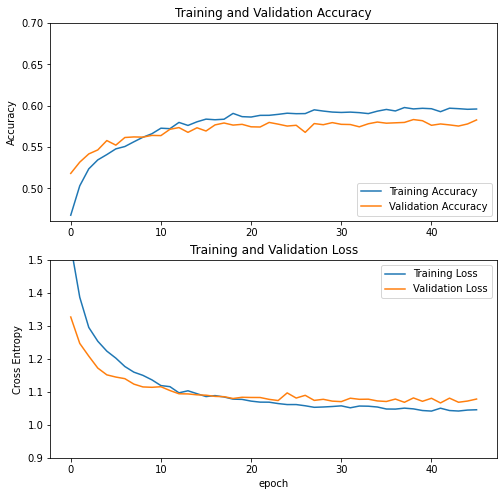

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.7])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.9,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
preds = model.predict(test_imgs)

In [ ]:
cart = ['Algae', 'Hard Coral', 'Other', 'Other Invertebrates', 'Soft Coral']

In [ ]:
preds_sub = [cart[np.argmax(pred)] for pred in preds]

In [ ]:
test_csv['label'] = preds_sub

In [ ]:
test_csv.to_csv('submission_transfer02.csv', index=False)

## Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train, y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_test, y_test),
                         callbacks=[callback])

Epoch 60/80
542/542 [==============================] - 28s 51ms/step - loss: 0.9280 - accuracy: 0.6371 - val_loss: 1.0116 - val_accuracy: 0.6105
Epoch 61/80
542/542 [==============================] - 28s 51ms/step - loss: 0.9207 - accuracy: 0.6468 - val_loss: 1.0398 - val_accuracy: 0.6024
Epoch 62/80
542/542 [==============================] - 28s 51ms/step - loss: 0.9217 - accuracy: 0.6467 - val_loss: 1.0139 - val_accuracy: 0.6102
Epoch 63/80
542/542 [==============================] - 28s 51ms/step - loss: 0.9129 - accuracy: 0.6463 - val_loss: 1.0066 - val_accuracy: 0.6086
Epoch 64/80
542/542 [==============================] - 28s 51ms/step - loss: 0.9090 - accuracy: 0.6489 - val_loss: 1.0235 - val_accuracy: 0.6010
Epoch 65/80
542/542 [==============================] - 28s 51ms/step - loss: 0.8974 - accuracy: 0.6515 - val_loss: 1.0346 - val_accuracy: 0.6114
Epoch 66/80
542/542 [==============================] - 28s 51ms/step - loss: 0.8923 - accuracy: 0.6544 - val_loss: 1.0289 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

136/136 [==============================] - 4s 27ms/step - loss: 1.0483 - accuracy: 0.6022


[1.0483033657073975, 0.6021679043769836]

In [ ]:
preds = model.predict(test_imgs)

In [ ]:
cart = ['Algae', 'Hard Coral', 'Other', 'Other Invertebrates', 'Soft Coral']

In [ ]:
preds_sub = [cart[np.argmax(pred)] for pred in preds]

In [ ]:
test_csv['label'] = preds_sub

In [ ]:
test_csv.to_csv('submission_transfer04.csv', index=False)